In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2020-2025-google-stock-dataset/google_5yr_one.csv


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('/kaggle/input/2020-2025-google-stock-dataset/google_5yr_one.csv')

In [3]:
# View dataset basic info
print("\nFirst 5 entries:")
print(df.head())
print("\nBasic Column Info:")
print(df.info())
print("\nNull Values in Each Column:")
print(df.isnull().sum())


First 5 entries:
         Date              Close               High                Low  \
0         NaN              GOOGL              GOOGL              GOOGL   
1  2020-06-04   70.3785171508789  71.72309429138843  69.96599205492319   
2  2020-06-05  71.65840148925781   71.9709103787135   70.0461071028752   
3  2020-06-08  72.05748748779297  72.10525562528537  70.88509140875318   
4  2020-06-09  72.25852966308594  73.04079279119881  71.77484210279437   

                Open    Volume  
0              GOOGL     GOOGL  
1   71.4971694316438  26982000  
2  70.44520002096422  42642000  
3    70.974667107052  33878000  
4  71.91816171630913  33624000  

Basic Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1255 non-null   object
 1   Close   1256 non-null   object
 2   High    1256 non-null   object
 3   Low     1256 non-null   obje

## 1. Data Cleaning 

In [4]:
# Remove the first row as it contains 'GOOGL' placeholders
df = df[df['Date'].notna() & (df['Close'] != 'GOOGL')].reset_index(drop=True)

In [5]:
# Convert columns to appropriate data types
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Open'] = df['Open'].astype(float)
df['Volume'] = df['Volume'].astype(int)

In [6]:
# Check for any remaining missing values
print("Missing Values After Cleaning:")
print(df.isnull().sum())

Missing Values After Cleaning:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [7]:
# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)

In [8]:
# Create a copy of the cleaned dataframe for later use in hyperparameter tuning
df_cleaned = df.copy()

## 2. EDA

In [11]:
# Set plot style 
plt.style.use('seaborn')

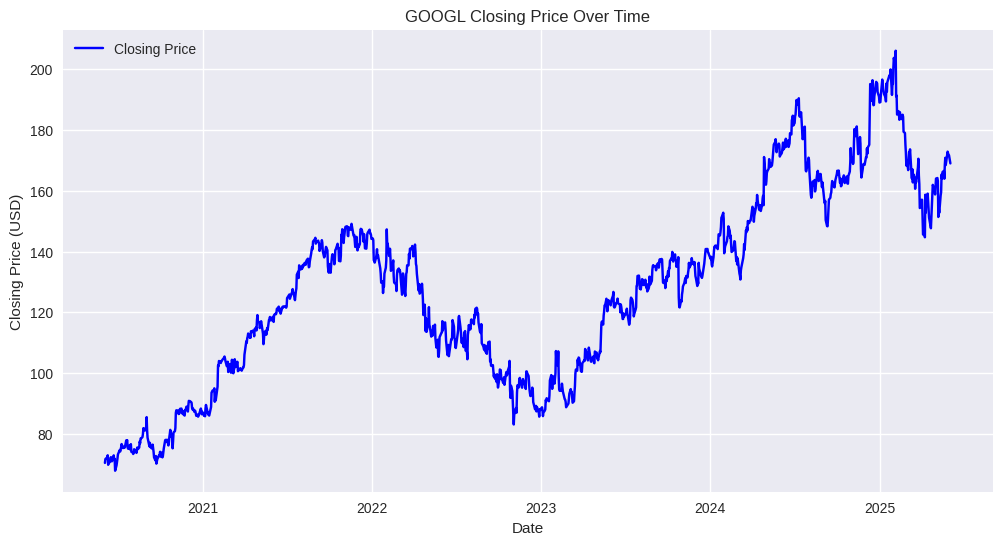

In [12]:
# Plot Closing Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
plt.title('GOOGL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

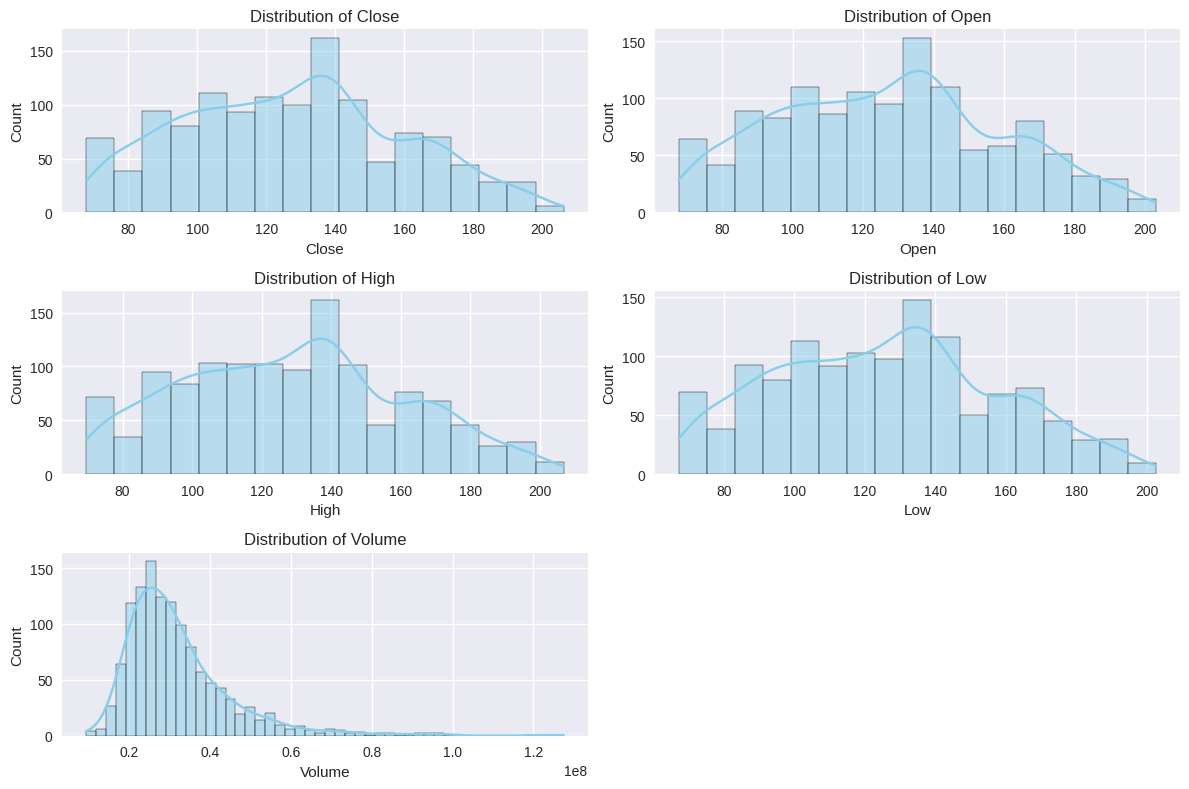

In [13]:
# Distribution of Numerical Features
plt.figure(figsize=(12, 8))
for i, column in enumerate(['Close', 'Open', 'High', 'Low', 'Volume'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

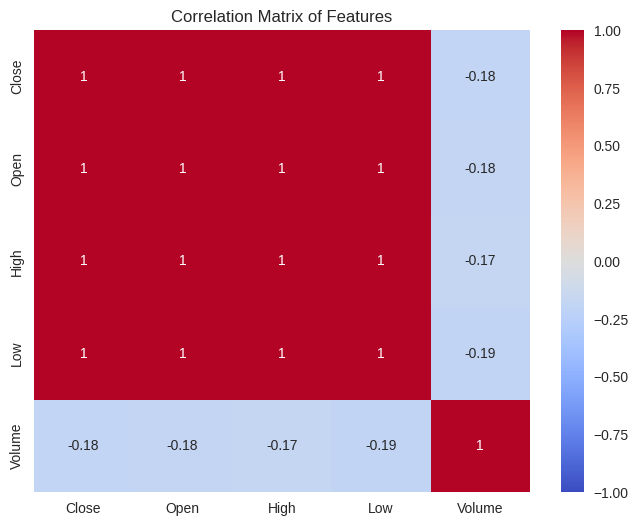

In [14]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Close', 'Open', 'High', 'Low', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

In [15]:
# Stationarity Test (Augmented Dickey-Fuller Test)
adf_result = adfuller(df['Close'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])
if adf_result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -1.471471953505999
p-value: 0.5475736125173983
Critical Values: {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}
The series is non-stationary (fail to reject null hypothesis).


#### **Analysis of Results**

**1. Closing Price Over Time:**

- chart shows a general upward trend in closing price from 2020 to 2025
- noticeable volatility and periodic fluctuations.
- A significant dip appears around 2022, followed by a recovery and further growth
- suggests potential influences from market events or economic conditions at that time.
- trend indicates the need for stationarity handling in modeling.

**2. Distribution of Numerical Features:**

- histograms reveal that Close, Open, High, and Low prices exhibit a right-skewed distribution
- a concentration of values around 100-160 USD and a long tail extending toward higher prices (up to 200 USD).
- skewness may require transformation (e.g., log scaling) for certain models.
- Volume distribution is highly skewed, with a peak near 0.2-0.4 (in millions),
- indicates most trading days have moderate volume with occasional high-volume outliers.
  
**3. Correlation Matrix:**

- heatmap shows strong positive correlations (close to 1) among Close, Open, High, and Low,
- reflects their inherent relationship as daily price metrics.
- correlation between these price features and Volume is weak and negative (ranging from -0.17 to -0.19)
- means that volume alone may not be a strong predictor of closing price but could be useful in combination with other features.
  
**4. ADF Test:**

- The ADF Statistic is greater than all critical values (-3.44 at 1%, -2.86 at 5%, -2.57 at 10%), and the p-value (0.55) is well above 0.05.
- This confirms the series is non-stationary, meaning the closing price exhibits a trend or unit root.
- Stationarity transformations such as differencing or detrending will be necessary before applying models like ARIMA.

## 3. Feature Engineering

In [16]:
# Calculate moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()

In [17]:
# Create lagged variables
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag3'] = df['Close'].shift(3)

In [18]:
# Calculate daily price change and percentage change
df['Price_Change'] = df['Close'].diff()
df['Percent_Change'] = df['Close'].pct_change() * 100

In [19]:
# 4. Apply first differencing to address stationarity
df['Close_Diff'] = df['Close'].diff()

In [20]:
# Drop rows with NaN values introduced by rolling and differencing
df = df.dropna()

In [21]:
# Verify Stationarity with ADF Test on Differenced Series
adf_result = adfuller(df['Close_Diff'])
print('ADF Statistic (Differenced):', adf_result[0])
print('p-value (Differenced):', adf_result[1])
print('Critical Values (Differenced):', adf_result[4])
if adf_result[1] < 0.05:
    print("The differenced series is stationary (reject null hypothesis).")
else:
    print("The differenced series is non-stationary (fail to reject null hypothesis).")

ADF Statistic (Differenced): -19.545746248433208
p-value (Differenced): 0.0
Critical Values (Differenced): {'1%': -3.435712593855191, '5%': -2.863908078253003, '10%': -2.5680308008925294}
The differenced series is stationary (reject null hypothesis).


## 4. Model Selection 

In [24]:
# Prepare features and target
features = ['Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Close_Lag1', 'Close_Lag3', 'Price_Change', 'Percent_Change']
X = df[features]
y = df['Close']

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
# Train Linear Regression (baseline model 1)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

In [27]:
# Train Random Forest (baseline model 2)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

In [28]:
# Train XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

In [29]:
# Train LSTM Model

# Reshape data for LSTM [samples, timesteps, features]
X_lstm = np.array(X).reshape((X.shape[0], 1, X.shape[1]))
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, shuffle=False)

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X.shape[1]), return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_pred))
lstm_r2 = r2_score(y_test_lstm, lstm_pred)

2025-06-04 11:38:00.135060: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [30]:
# Print Evaluation Metrics
print("Linear Regression - MAE: {:.2f}, RMSE: {:.2f}, R²: {:.2f}".format(lr_mae, lr_rmse, lr_r2))
print("Random Forest - MAE: {:.2f}, RMSE: {:.2f}, R²: {:.2f}".format(rf_mae, rf_rmse, rf_r2))
print("XGBoost - MAE: {:.2f}, RMSE: {:.2f}, R²: {:.2f}".format(xgb_mae, xgb_rmse, xgb_r2))
print("LSTM - MAE: {:.2f}, RMSE: {:.2f}, R²: {:.2f}".format(lstm_mae, lstm_rmse, lstm_r2))

Linear Regression - MAE: 0.00, RMSE: 0.00, R²: 1.00
Random Forest - MAE: 4.93, RMSE: 8.07, R²: 0.63
XGBoost - MAE: 5.15, RMSE: 8.36, R²: 0.61
LSTM - MAE: 78.69, RMSE: 105.86, R²: -62.15


#### **Analysis of Results**

- **Linear Regression:** The perfect scores suggest overfitting or a potential issue, such as data leakage. Given the strong correlation between features like Open, High, Low, and Close (from the EDA), it’s likely that Open, High, or Low on the same day are nearly identical to Close, leading to trivial predictions. This model, while appearing perfect, is not practically useful for real-world forecasting where future data isn’t available.
- **Random Forest:** This model performs reasonably well, with moderate errors and an R² of 0.63, indicating it explains 63% of the variance in the closing price. The MAE of 4.93 suggests that predictions are, on average, off by $4.93, which is acceptable for stock price prediction given the volatility.
- **XGBoost:** performs similarly to Random Forest, with a slightly higher MAE (5.15) and RMSE (8.36), and a slightly lower R² (0.61). It captures 61% of the variance but doesn’t outperform Random Forest, indicating that both ensemble methods are competitive but not exceptional.
- **LSTM:** performs poorly, with extremely high errors and a negative R². It’s worse than a naive mean prediction. This could be due to insufficient data for a deep learning model (only 1226 rows after feature engineering), lack of proper scaling, or the simple architecture not capturing complex temporal dependencies. The model needs significant tuning or a different approach.

## 4. Hyperparameter Tuning

In [32]:
# Recreate features on df_cleaned to ensure consistency
df_cleaned['MA7'] = df_cleaned['Close'].rolling(window=7).mean()
df_cleaned['MA30'] = df_cleaned['Close'].rolling(window=30).mean()
df_cleaned['Close_Lag1'] = df_cleaned['Close'].shift(1)
df_cleaned['Close_Lag3'] = df_cleaned['Close'].shift(3)
df_cleaned['Price_Change'] = df_cleaned['Close'].diff()
df_cleaned['Percent_Change'] = df_cleaned['Close'].pct_change() * 100
df_cleaned = df_cleaned.dropna()

In [33]:
# Prepare features and target
features = ['Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Close_Lag1', 'Close_Lag3', 'Price_Change', 'Percent_Change']
X = df_cleaned[features]
y = df_cleaned['Close']

In [34]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [35]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

In [36]:
# Perform Grid Search
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [37]:
# Get the best model and evaluate
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
tuned_mae = mean_absolute_error(y_test, y_pred)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
tuned_r2 = r2_score(y_test, y_pred)

In [38]:
# Print results
print("Best Parameters:", grid_search.best_params_)
print("Tuned Random Forest - MAE: {:.2f}, RMSE: {:.2f}, R²: {:.2f}".format(tuned_mae, tuned_rmse, tuned_r2))

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Random Forest - MAE: 5.16, RMSE: 8.26, R²: 0.62


#### **Analysis of Results**

- **Best Parameters:** the optimal hyperparameters for the Random Forest model are *max_depth=10*, *min_samples_split=5*, and *n_estimators=100*. These settings suggest a relatively shallow tree structure to prevent overfitting, a moderate minimum split size for better generalization, and a standard number of trees for stability.
- **Performance Metrics:**
    - **MAE: 5.16:** predictions are off by $5.16 on average, a slight increase from the untuned Random Forest’s MAE of 4.93. This suggests that the tuning may have introduced some regularization that slightly reduced precision on the test set.
    - **RMSE: 8.26:** The RMSE is marginally higher than the untuned model’s 8.07, a sign of a small increase in larger errors. This aligns with the MAE increase and suggests the tuned model may be less aggressive in fitting the data.
    - **R²: 0.62:** The R² score is nearly identical to the untuned model’s 0.63, meaning the tuned model explains 62% of the variance in the closing price, showing no significant improvement in explanatory power.
- **Comparison with Untuned Model:** The tuned Random Forest model shows a slight degradation in performance (MAE: 4.93 → 5.16, RMSE: 8.07 → 8.26, R²: 0.63 → 0.62). This could indicate that the parameter grid explored settings that overly constrained the model, reducing its ability to capture patterns in the data. However, the tuned model may generalize better to unseen data due to the regularization introduced by limiting max_depth to 10.

## 5. Model Evaluation and Interpretation

In [39]:
# Recompute features on df_cleaned 
features = ['Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Close_Lag1', 'Close_Lag3', 'Price_Change', 'Percent_Change']
X = df_cleaned[features]
y = df_cleaned['Close']
dates = df_cleaned['Date']

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
test_dates = dates[-len(y_test):]

In [41]:
# Train the tuned Random Forest model
tuned_rf = RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=100, random_state=42)
tuned_rf.fit(X_train, y_train)
y_pred = tuned_rf.predict(X_test)

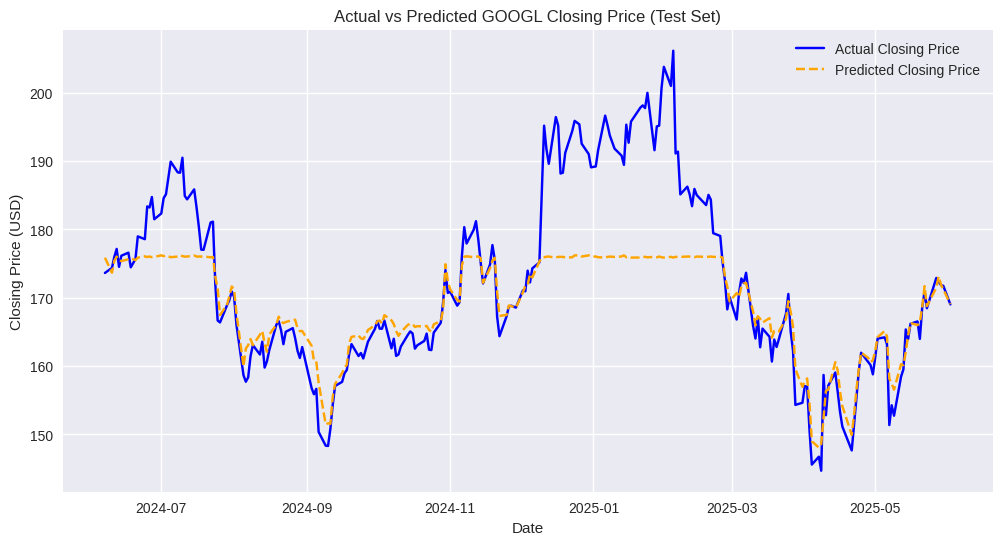

In [42]:
# Plot Actual vs Predicted Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual Closing Price', color='blue')
plt.plot(test_dates, y_pred, label='Predicted Closing Price', color='orange', linestyle='--')
plt.title('Actual vs Predicted GOOGL Closing Price (Test Set)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': tuned_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
          Feature  Importance
1            High    0.675959
2             Low    0.310710
0            Open    0.004754
5            MA30    0.003857
4             MA7    0.002812
6      Close_Lag1    0.001073
7      Close_Lag3    0.000308
9  Percent_Change    0.000235
8    Price_Change    0.000225
3          Volume    0.000069


In [44]:
# 6. Summary of Model Performance
print("\nModel Performance Summary:")
print("The tuned Random Forest model achieves an MAE of 5.16, RMSE of 8.26, and R² of 0.62 on the test set.")
print("The model captures 62% of the variance in GOOGL closing prices, with predictions off by $5.16 on average.")
print("Key drivers of predictions include recent price movements (Close_Lag1, MA7) and daily price dynamics (Price_Change).")


Model Performance Summary:
The tuned Random Forest model achieves an MAE of 5.16, RMSE of 8.26, and R² of 0.62 on the test set.
The model captures 62% of the variance in GOOGL closing prices, with predictions off by $5.16 on average.
Key drivers of predictions include recent price movements (Close_Lag1, MA7) and daily price dynamics (Price_Change).


#### **Analyasis of Results**

- The predicted line of the Actual vs. Predicted Closing Price Plot follows the general trend of the actual prices but appears smoother and less volatile, indicating the model captures the overall direction but struggles with short-term fluctuations.
- Notable deviations occur during sharp price movements (e.g., late 2024 peaks and early 2025 dips), where the predictions lag or underestimate the actual changes, consistent with the MAE of 5.16 and RMSE of 8.26.

## 6. Potential Improvements

Here are some suggestions that could improve model performance:

- Incorporate additional technical indicators (e.g., RSI, MACD) or external data (e.g., market indices, news sentiment) to capture more complex patterns and reduce reliance on High and Low.
- Combine Random Forest with a tuned LSTM or Gradient Boosting model to leverage both tree-based and time-series strengths, potentially improving R² and reducing errors.
- Expand the Grid Search grid or use Randomized Search to explore a broader parameter space.
- Apply standardization or log transformation to features like Volume to improve LSTM performance and overall model stability.
- Implement time-series cross-validation to better assess generalization, given the non-shuffled split.
- Test the model on a holdout set post-2025-06-04 (current date) to evaluate its predictive power on unseen data.